## Malawi - Exploration and Modelling using an alternative grouping of features

Here, we separate out the visibility changes to it's own feature and include the fullscreen feature into the contextual changes. Everything else remains the same.

In [192]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_context('paper')
np.random.seed(42)

In [193]:
# read in the interaction metrics
statistics = pd.read_csv('data/malawi_statistics.csv')

# read in the contextual data
contextual = pd.read_csv('data/malawi_contextual_data.csv')

# get the distance from end metrics
target_metrics = pd.read_csv('data/abandonment_metrics.csv')
target_metrics = target_metrics[target_metrics.story == 'malawi'].copy()

print(f"Number of users: {len(statistics.index)}")
print(f"Number of contextual samples: {len(contextual.index)}")
print(f"Number of samples in target metrics: {len(target_metrics.index)}")

Number of users: 21250
Number of contextual samples: 18779
Number of samples in target metrics: 21169


Merge the data into a single dataframe

In [194]:
metrics = pd.merge(target_metrics, contextual, on = 'user', how = 'left')
metrics = metrics.merge(statistics, on = 'user', how = 'left')

print(f"Length of merged dataframe: {len(metrics.index)}")

Length of merged dataframe: 21169


As we're focusing on predicting the distance from the end, there are some features in the data that do not make sense to include - they'll increase depending on how far away someone is from the end. 

For example, the number of narrative elements seen will increase as a user progresses through the story, creating a feature that encodes the distance to the end. A similar effect will be seen with the session length and link choices clicked.

In [195]:
columns_to_drop = [
    # interaction-based features
    'LINK_CHOICE_CLICKED', 'NARRATIVE_ELEMENT_CHANGE', 'SUBTITLES_BUTTON_CLICKED',
    'USER_SET_VARIABLE', 'LINK_CHOICE_CLICKED_proportion', 'NARRATIVE_ELEMENT_CHANGE_proportion',
    'SUBTITLES_BUTTON_CLICKED_proportion', 'USER_SET_VARIABLE_proportion', 'total_events',
    'last_ne_seen',
    # time-based features
    'std_nec_time', 'med_nec_time', 'norm_std_nec_time', 'session_length', 'hidden_time', 
    'time_to_completion', 'raw_session_length', 'pre_std_nec_time', 'pre_norm_std_nec_time',
    # misc
    'reach_end'
]

metrics = metrics.drop(columns = columns_to_drop)

There is some additional contextual data that we can include that isn't already present - the orientation prior to entering the substory. This gives us an indication as to the orientation of the device, along with being able to infer whether the user is a mobile user or not. 

In [196]:
import pickle 

# load in the additional metadata
meta = pickle.load(open('data/malawi_user_metadata.pickle', 'rb'))

# create a dataframe containing the particular feature that we're interested in
meta = pd.DataFrame(
    [(user, values['pre_substory_orientation']) for user, values in meta.items()],
    columns = ['user', 'pre_substory_orientation']
)

# merge it with the metrics dataframe, including a suffixes to help with removing any duplicates (there shouldn't be any, but it's worth doing)
metrics = metrics.merge(right = meta, how = 'left', on = 'user', suffixes = ('', '_drop'))
metrics = metrics.drop(metrics.filter(regex = '_drop$').columns.tolist(), axis = 1)

**Get Data Statistics**

In [197]:
# get all of the events for the substory
event_data = pickle.load(open('data/malawi_data.pickle', 'rb'))

user_set = set(metrics.user.tolist())

event_lengths = [
    len(s_data['events'])
    for s_user, s_data in event_data.items()
    if s_user in user_set
]

assert len(user_set) == len(event_lengths)
print(f"Number of users: {len(user_set)}")
print(f"Events: M: {round(np.mean(event_lengths), 3)}, STD: {round(np.std(event_lengths), 3)}")
print(f"Total Number of events: {np.sum(event_lengths)}")

Number of users: 21169
Events: M: 69.577, STD: 265.055
Total Number of events: 1472865


**Separate out the UES Users**

In [198]:
ues_users = pd.read_csv('data/click_user_engagement_metrics.csv')
ues_users['present'] = np.where(ues_users.user_id.isin(metrics.user), True, False)
ues_users['present'].value_counts()

True     332
False    168
Name: present, dtype: int64

In [199]:
# drop the users where present is false 
ues_users = ues_users.drop(ues_users[ues_users.present == False].index)

# merge the metrics into the ues_users dataframe
ues_users = ues_users.merge(
    right = metrics, how = 'left', left_on = 'user_id', right_on = 'user'
)

# add a column to the metrics dataframe so we can drop those rows 
metrics['ues_user'] = np.where(metrics.user.isin(ues_users.user_id), True, False)

# drop the users that are ues_users from the metrics dataframe
metrics = metrics.drop(metrics[metrics.ues_user == True].index)

There should be no negative values present in the data - these can occur with data outliers

In [200]:
# remove them
metrics = metrics[metrics.select_dtypes(include = [np.number]).ge(0).all(1)]
metrics.describe()

,distance,pre_avg_nec_time,pre_norm_avg_nec_time,pre_link_choice_clicked,pre_narrative_element_change,pre_link_choice_ratio,avg_nec_time,norm_avg_nec_time,SP,MP,...,VOLUME_CHANGED_proportion,BACK_BUTTON_CLICKED_proportion,WINDOW_ORIENTATION_CHANGE_proportion,FULLSCREEN_BUTTON_CLICKED_proportion,VIDEO_SCRUBBED_proportion,PLAY_PAUSE_BUTTON_CLICKED_proportion,SEEK_BACKWARD_BUTTON_CLICKED_proportion,NEXT_BUTTON_CLICKED_proportion,SEEK_FORWARD_BUTTON_CLICKED_proportion,BROWSER_VISIBILITY_CHANGE_proportion
count,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,...,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000,17259.000000
mean,1.776928,69.390699,0.850351,8.061707,6.052031,1.335417,139.100178,1.675647,1.663074,0.858856,...,0.000007,0.000050,0.000572,0.000095,0.000198,0.000139,0.000023,0.000297,0.000162,0.001247
std,1.733375,470.018525,5.196269,6.543379,0.601273,1.084718,1688.962210,21.499369,2.845194,1.582918,...,0.000108,0.000364,0.001099,0.000377,0.000725,0.000545,0.000203,0.000965,0.000758,0.001785
min,0.000000,7.839000,0.108000,1.000000,4.000000,0.125000,0.008000,0.000128,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.070000,0.743000,5.000000,6.000000,0.833000,32.366958,0.413848,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,55.738000,0.759000,6.000000,6.000000,1.000000,49.980333,0.762918,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,60.162000,0.783000,9.000000,6.000000,1.333000,94.105688,1.003306,2.000000,1.000000,...,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002000
max,4.000000,47953.917000,536.774000,152.000000,54.000000,25.333000,123527.750500,1157.063752,38.000000,30.000000,...,0.005000,0.006056,0.009500,0.005000,0.007500,0.008125,0.006667,0.008889,0.008511,0.009783


**Grouping Features**

To simplify the modelling and exploration process, we'll group related features together - i.e., back button clicks and seek backward clicks as backward navigation. We know from prior work that a lot of these events record low counts, so there could be additional information when grouping. **This is where we've updated from the other notebook, it's where browser visibility changes are own their own and fullscreen is included in contextual**

In [201]:
metrics.columns

Index(['user', 'distance', 'story', 'pre_avg_nec_time',
       'pre_norm_avg_nec_time', 'pre_link_choice_clicked',
       'pre_narrative_element_change', 'pre_link_choice_ratio', 'avg_nec_time',
       'norm_avg_nec_time', 'SP', 'MP', 'LP', 'VLP', 'VOLUME_CHANGED',
       'BACK_BUTTON_CLICKED', 'WINDOW_ORIENTATION_CHANGE',
       'FULLSCREEN_BUTTON_CLICKED', 'VIDEO_SCRUBBED',
       'PLAY_PAUSE_BUTTON_CLICKED', 'SEEK_BACKWARD_BUTTON_CLICKED',
       'NEXT_BUTTON_CLICKED', 'SEEK_FORWARD_BUTTON_CLICKED',
       'BROWSER_VISIBILITY_CHANGE', 'VOLUME_CHANGED_proportion',
       'BACK_BUTTON_CLICKED_proportion',
       'WINDOW_ORIENTATION_CHANGE_proportion',
       'FULLSCREEN_BUTTON_CLICKED_proportion', 'VIDEO_SCRUBBED_proportion',
       'PLAY_PAUSE_BUTTON_CLICKED_proportion',
       'SEEK_BACKWARD_BUTTON_CLICKED_proportion',
       'NEXT_BUTTON_CLICKED_proportion',
       'SEEK_FORWARD_BUTTON_CLICKED_proportion',
       'BROWSER_VISIBILITY_CHANGE_proportion', 'pre_substory_orientation',
 

In [202]:
from lib.helpers import COUNT_GROUPS, PROPORTION_GROUPS

# create the grouped features by summing the count values and the proportion values (multiplied by 100)
for group, columns in COUNT_GROUPS['alternative_groupings'].items():
    metrics[group] = metrics[columns].sum(axis = 1)
    
for group, columns in PROPORTION_GROUPS['alternative_groupings'].items():
    if group == 'browser_visibility_change_proportion':
        metrics = metrics.rename(columns = {columns[0]: group})
        metrics[group] = metrics[group].apply(lambda x: x * 100)
    else:
        metrics[group] = metrics[columns].sum(axis = 1) * 100
        
# we now want to drop the original columns 
import itertools 
droppable_columns = list(
    itertools.chain.from_iterable(list(COUNT_GROUPS['alternative_groupings'].values()))
)
droppable_columns += list(
    itertools.chain.from_iterable(list(PROPORTION_GROUPS['alternative_groupings'].values()))
)
droppable_columns.remove('BROWSER_VISIBILITY_CHANGE_proportion')

metrics = metrics.drop(columns = droppable_columns)
metrics.columns

Index(['user', 'distance', 'story', 'pre_avg_nec_time',
       'pre_norm_avg_nec_time', 'pre_link_choice_clicked',
       'pre_narrative_element_change', 'pre_link_choice_ratio', 'avg_nec_time',
       'norm_avg_nec_time', 'SP', 'MP', 'LP', 'VLP',
       'browser_visibility_change_proportion', 'pre_substory_orientation',
       'ues_user', 'back_nav', 'forward_nav', 'contextual', 'video_general',
       'browser_visibility_change', 'back_nav_proportion',
       'forward_nav_proportion', 'contextual_proportion',
       'video_general_proportion'],
      dtype='object')

In [203]:
metrics = metrics[metrics.avg_nec_time < metrics.avg_nec_time.quantile(0.97)]
metrics = metrics[metrics.norm_avg_nec_time < metrics.norm_avg_nec_time.quantile(0.96)]

print(f"Number of samples: {len(metrics.index)}")

metrics = metrics[metrics.pre_avg_nec_time < metrics.pre_avg_nec_time.quantile(0.99)]
metrics = metrics[metrics.pre_norm_avg_nec_time < metrics.pre_norm_avg_nec_time.quantile(0.99)]

print(f"Number of samples: {len(metrics.index)}")

Number of samples: 16071
Number of samples: 15750


**Encoding Categorical Variables**

In [204]:
metrics[['back_nav', 'forward_nav']].describe()

,back_nav,forward_nav
count,15750.000000,15750.000000
mean,0.176635,1.009841
std,1.569492,3.621107
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,87.000000,92.000000


In [205]:
num_users = len(metrics.index)
metrics[['back_nav', 'forward_nav']].apply(lambda x: (np.count_nonzero(x) / num_users) * 100)

back_nav        3.225397
forward_nav    16.133333
dtype: float64

In [206]:
metrics[['back_nav', 'forward_nav']] = metrics[['back_nav', 'forward_nav']].astype(bool)
metrics[['back_nav', 'forward_nav']].apply(pd.Series.value_counts, normalize = True) * 100

metrics['mobile'] = np.where(metrics.pre_substory_orientation.isin(['horizontal', 'vertical']), True, False)
metrics['pre_substory_orientation'] = np.where(
    (metrics.pre_substory_orientation == 'unknown'), 'horizontal', metrics.pre_substory_orientation
)

In [207]:
metrics.mobile.value_counts(normalize = True) * 100

True     54.012698
False    45.987302
Name: mobile, dtype: float64

In [208]:
metrics.pre_substory_orientation.value_counts(normalize = True) * 100

horizontal    99.593651
vertical       0.406349
Name: pre_substory_orientation, dtype: float64

In [209]:
metrics = pd.get_dummies(metrics, columns = ['pre_substory_orientation'], drop_first = True)

In [210]:
from lib.helpers import PRETTY_NAMES
metrics = metrics.rename(columns = PRETTY_NAMES)
metrics.columns

Index(['user', 'distance', 'story', 'Avg NEC Time (Pre)',
       'Norm Avg NEC Time (Pre)', '# Link Choices (Pre)', '# NEC (Pre)',
       'Link Choice Ratio (Pre)', 'Avg NEC Time', 'Norm Avg NEC Time',
       '# Short Pauses', '# Medium Pauses', '# Long Pauses',
       '# Very Long Pauses', 'Visibility Change (Proportion)', 'ues_user',
       'Navigation - Backwards (Bool)', 'Navigation - Forward (Bool)',
       '# Contextual Changes', '# General Video Controls',
       '# Visibility Change', 'Navigation - Backwards (Proportion)',
       'Navigation - Forwards (Proportion)', 'Contextual Changes (Proportion)',
       'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
       'Vertical Orientation (Pre) Bool'],
      dtype='object')

### Features - Exploration

**Average NEC Time and Normalised Average NEC Time**

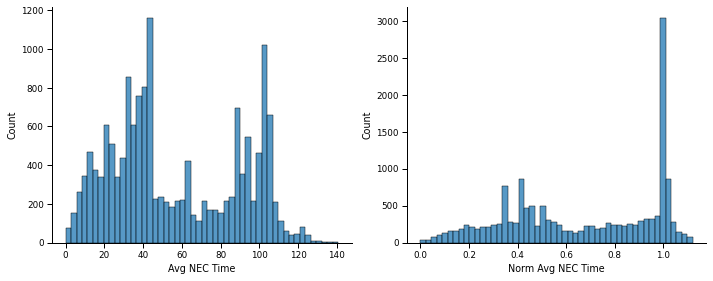

In [211]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
sns.histplot(
    data = metrics,
    x = 'Avg NEC Time', stat = 'count', bins = 50, ax = ax[0]
)
sns.histplot(
    data = metrics,
    x = 'Norm Avg NEC Time', stat = 'count', bins = 50, ax = ax[1]
)
sns.despine()
plt.tight_layout()
plt.show()

We can see that for the average time spent on narrative elements, there appear to be groupings - with a high proportion of users recording 1.00 for the normalised version of the metric (meaning that they saw 100% of the narrative element). However, there are users that viewed less than half. 

Let's include the target metric as a hue and stack the histograms

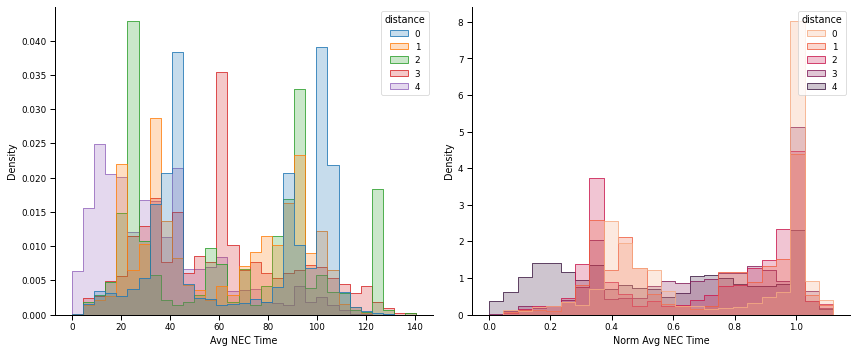

In [212]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
sns.histplot(
    data = metrics,
    x = 'Avg NEC Time', hue = 'distance', element = 'step', stat = 'density', common_norm = False,
    ax = ax[0], palette = sns.color_palette(n_colors=5)
)
sns.histplot(
    data = metrics,
    x = 'Norm Avg NEC Time', hue = 'distance', element = 'step', stat = 'density', common_norm = False,
    ax = ax[1], palette = sns.color_palette("rocket_r", n_colors = 5)
)
sns.despine()
plt.tight_layout()
plt.show()

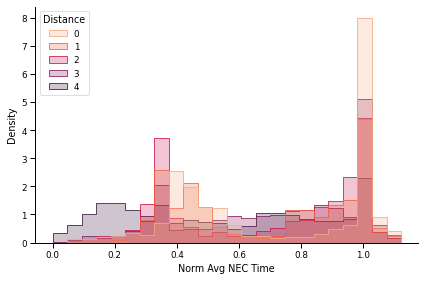

In [213]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_ 
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc = new_loc, title = title, **kws)

p = sns.histplot(
    data = metrics, x = 'Norm Avg NEC Time', hue = 'distance', 
    element = 'step', stat = 'density', common_norm = False, 
    palette = sns.color_palette('rocket_r', n_colors = 5)
)
p.legend_.set_title('Distance')
move_legend(p, 'upper left')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_normalised_average_nec_time_across_distances.png')

See a similar trend here, users that drop out earlier in the experience have a lower normalised average - they watched less of the narrative elements. This is likely due to the fact they've dropped out, probably during the early stages of a narrative element situated the beginning.

Users that finish or drop out closer to the end peak at watching 100% of narrative elements, with a smaller proportion than Cars going beyond that.

In [214]:
metrics[[
    '# Contextual Changes', '# General Video Controls', '# Visibility Change',
    '# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'
]].describe()

,# Contextual Changes,# General Video Controls,# Visibility Change,# Short Pauses,# Medium Pauses,# Long Pauses,# Very Long Pauses
count,15750.000000,15750.000000,15750.000000,15750.000000,15750.000000,15750.000000,15750.000000
mean,0.671810,0.534413,0.893524,1.568190,0.806095,0.504508,2.627810
std,1.748426,2.052193,1.638488,2.714238,1.508496,0.818975,2.173826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,4.000000
max,76.000000,43.000000,33.000000,38.000000,26.000000,10.000000,51.000000


In [215]:
metrics.groupby('distance')[[
    '# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'
]].aggregate(['mean', 'std', 'median'])

# Short Pauses                  # Medium Pauses                   \
                   mean       std median            mean       std median   
distance                                                                    
0              1.762008  3.271096      0        0.877992  1.823779      0   
1              1.668608  2.700086      1        0.780431  1.561151      0   
2              1.556489  2.497538      1        0.658263  1.334280      0   
3              1.621246  2.452563      1        0.724138  1.272362      0   
4              1.246108  1.847768      1        0.781403  1.056725      1   

         # Long Pauses                  # Very Long Pauses                   
                  mean       std median               mean       std median  
distance                                                                     
0             0.485714  0.889598      0           3.798919  2.130083      4  
1             0.527665  0.825700      0           3.182877  2.138636      2  
2             0.436975  0.754733      0           2.287582  1.524082      2  
3             0.566185  0.833903      0           2.180756  1.853009      2  
4             0.513756  0.714812      0           1.056515  1.228399      1

**Descriptive Statistics - Proportion of Events**

How many users registered at least one in the interaction metrics?

In [216]:
interaction_metrics_based_on_interactions = [
    '# Link Choices (Pre)', '# NEC (Pre)', '# Short Pauses', 
    '# Medium Pauses', '# Long Pauses', '# Very Long Pauses', '# Contextual Changes', 
    '# General Video Controls', '# Visibility Change'
]
num_users = len(metrics.index)
metrics[interaction_metrics_based_on_interactions].apply(lambda x: (np.count_nonzero(x) / num_users) * 100)

# Link Choices (Pre)        100.000000
# NEC (Pre)                 100.000000
# Short Pauses               53.561905
# Medium Pauses              39.282540
# Long Pauses                36.622222
# Very Long Pauses           84.965079
# Contextual Changes         35.644444
# General Video Controls     16.069841
# Visibility Change          47.720635
dtype: float64

In [217]:
metrics['General Video Controls (Proportion)'].describe()

count    15750.000000
mean         0.027811
std          0.084997
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.750000
Name: General Video Controls (Proportion), dtype: float64

**Correlation Analysis**

In [218]:
interaction_metrics = [
    'Avg NEC Time (Pre)', 'Norm Avg NEC Time (Pre)', '# Link Choices (Pre)', '# NEC (Pre)', 
    'Link Choice Ratio (Pre)', 'Avg NEC Time', 'Norm Avg NEC Time', '# Short Pauses', 
    '# Medium Pauses', '# Long Pauses', '# Very Long Pauses', 'Visibility Change (Proportion)',
    'Navigation - Backwards (Bool)', 'Navigation - Forward (Bool)', '# Contextual Changes', 
    '# General Video Controls', '# Visibility Change', 'Navigation - Backwards (Proportion)',
    'Navigation - Forwards (Proportion)', 'Contextual Changes (Proportion)',
    'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
    'Vertical Orientation (Pre) Bool'
]

metrics[interaction_metrics + ['distance']].corr(method = 'spearman').filter(['distance']).drop(['distance'])

,distance
Avg NEC Time (Pre),-0.034433
Norm Avg NEC Time (Pre),-0.069817
# Link Choices (Pre),0.088467
# NEC (Pre),-0.007749
Link Choice Ratio (Pre),0.088835
Avg NEC Time,-0.416169
Norm Avg NEC Time,-0.254503
# Short Pauses,0.025539
# Medium Pauses,0.101564
# Long Pauses,0.065314


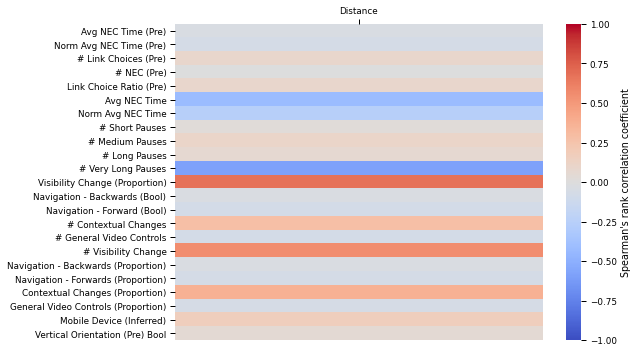

In [219]:
fig, ax = plt.subplots(figsize = (9, 5))
p = sns.heatmap(
    data = metrics[
        interaction_metrics + ['distance']
    ].corr(method = 'spearman').filter(['distance']).drop(['distance']), 
    cmap = sns.color_palette('coolwarm', as_cmap = True), 
    cbar_kws = {'label': "Spearman's rank correlation coefficient"}, 
    ax = ax, vmin = -1.00, vmax = 1.00 
)
p.xaxis.set_ticks_position('top')
p.set(xticklabels = ['Distance'])
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-metrics-distance-correlations.png')

**Correlation Analysis between Interaction Metrics**

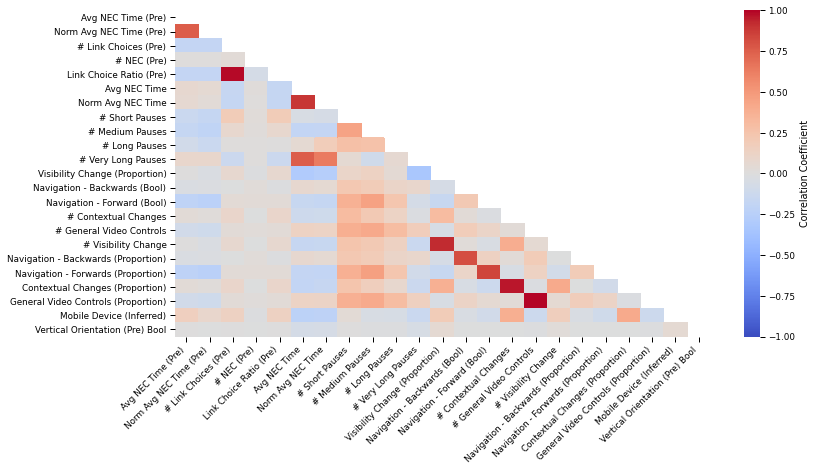

In [220]:
from lib.helpers import correlation_between_metrics

corr_results = pd.DataFrame.from_dict(correlation_between_metrics(metrics, interaction_metrics))

fig, ax = plt.subplots(figsize = (12, 6))
p = sns.heatmap(
    corr_results, xticklabels = True, yticklabels = True, ax = ax, 
    vmin = -1.00, vmax = 1.00, cmap = sns.color_palette('coolwarm', as_cmap = True), 
    cbar_kws = {'label': "Correlation Coefficient"}, 
    mask = np.triu(np.ones_like(corr_results, dtype = np.bool))
)
p.set_xticklabels(p.get_xticklabels(), rotation = 45, ha = 'right')
plt.show()

**Statistical Tests for Significant Differences**

We iterate over each interaction metric and split by the difference and compute the Kruskal Wallis test.

In [221]:
from lib.helpers import statistical_differences

distance_values = sorted(metrics['distance'].unique().tolist())
results = statistical_differences(metrics, interaction_metrics, distance_values)
pd.DataFrame.from_dict(results, orient = 'index')

,kw_statistic,p_value,sig
Avg NEC Time (Pre),31.209865,2.773965e-06,significant at 0.001
Norm Avg NEC Time (Pre),113.321102,1.424013e-23,significant at 0.001
# Link Choices (Pre),130.984908,2.397513e-27,significant at 0.001
# NEC (Pre),2.598230,6.271367e-01,non-significant
Link Choice Ratio (Pre),131.802338,1.602949e-27,significant at 0.001
Avg NEC Time,3143.193716,0.000000e+00,significant at 0.001
Norm Avg NEC Time,1189.380031,3.194686e-256,significant at 0.001
# Short Pauses,45.088708,3.810644e-09,significant at 0.001
# Medium Pauses,218.253245,4.454535e-46,significant at 0.001
# Long Pauses,86.453352,7.457229e-18,significant at 0.001


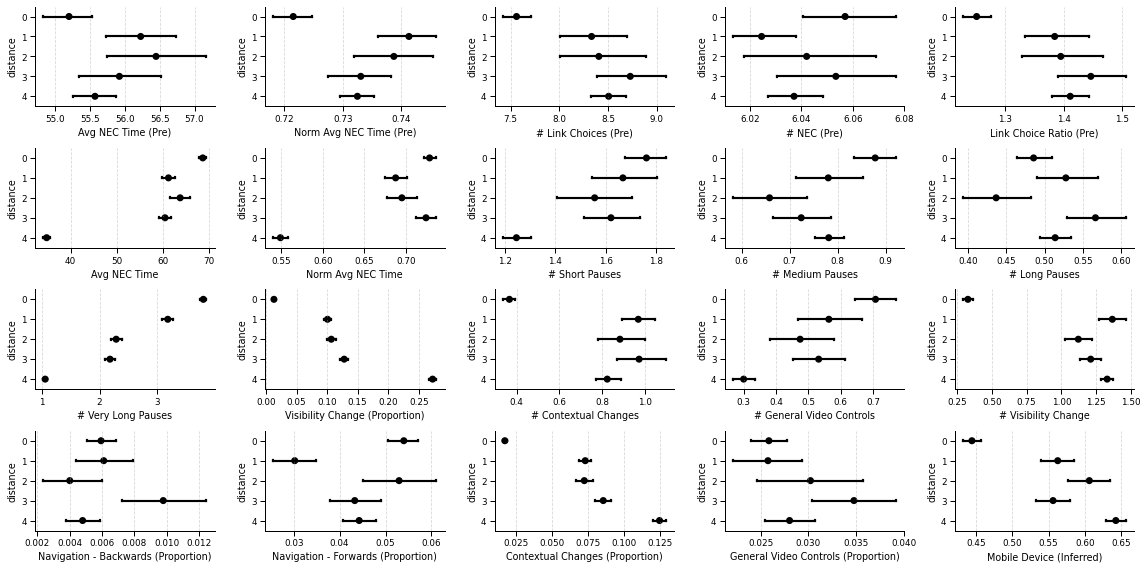

In [222]:
interaction_metrics_no_bool = [ 
    metric 
    for metric in interaction_metrics
    if 'Bool' not in metric
]

fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (16, 8))

for idx, ax in enumerate(axes.ravel()):
    p = sns.pointplot(
        y = 'distance', x = interaction_metrics_no_bool[idx], 
        data = metrics, join = False, capsize = 0.05, 
        color = 'black', orient = 'h', ax = ax 
    )
    p.set(xlabel = interaction_metrics_no_bool[idx])
    p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-metric-distance-effect-plot.png')

Much like the cars plot, there is a lot of noise - plus the actual value of the features in real terms are really low. In both cases, the the number of contextual changes is much lower for users that reach the end (these are window orientation changes and fullscreen changes).

### Modelling

In [223]:
features = list(PRETTY_NAMES.values())
target = 'distance'

In [224]:
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import PoissonRegressor, LinearRegression, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lib.helpers import print_cross_validation_results as print_cv 
from lib.helpers import model_performance

scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_poisson_deviance']

y = metrics['distance']
X = metrics[features]

dummy_cv = cross_validate(estimator = DummyRegressor(strategy = 'mean'), X = X, y = y, scoring = scoring, cv = 10)
poisson_cv = cross_validate(
    estimator = make_pipeline(
        StandardScaler(),
        PoissonRegressor()
    ), 
    X = X, y = y, scoring = scoring, cv = 10
)

dt_cv = cross_validate( # max_depth is set to a reasonable number.
    estimator = DecisionTreeRegressor(criterion = 'poisson', random_state = 42),
    X = X, y = y, scoring = scoring, cv = 10
)
gbrt_cv = cross_validate(
    estimator = HistGradientBoostingRegressor(loss = 'poisson', max_leaf_nodes = 128, random_state = 42),
    X = X, y = y, scoring = scoring, cv = 10
)

print_cv(dummy_cv, 'Dummy', scoring)
print_cv(poisson_cv, 'Poisson Regressor', scoring)
print_cv(dt_cv, 'Decision Tree (Poisson criterion)', scoring)
print_cv(gbrt_cv, 'Hist GBT Regressor (Poisson Loss)', scoring)

Dummy
mean squared error: 3.021 (STD: 0.036)
mean absolute error: 1.635 (STD: 0.016)
mean poisson deviance: 2.202 (STD: 0.147)

Poisson Regressor
mean squared error: 1.518 (STD: 0.046)
mean absolute error: 1.062 (STD: 0.011)
mean poisson deviance: 1.328 (STD: 0.101)

Decision Tree (Poisson criterion)
mean squared error: 1.217 (STD: 0.071)
mean absolute error: 0.529 (STD: 0.019)
mean poisson deviance: 0.884 (STD: 0.074)

Hist GBT Regressor (Poisson Loss)
mean squared error: 0.527 (STD: 0.047)
mean absolute error: 0.404 (STD: 0.020)
mean poisson deviance: 0.422 (STD: 0.053)



In [225]:
from lib.helpers import paired_ttest

models = [
    make_pipeline(StandardScaler(), PoissonRegressor()),
    DecisionTreeRegressor(criterion = 'poisson', random_state = 42),
    HistGradientBoostingRegressor(loss = 'poisson', max_leaf_nodes = 128, random_state = 42)
]
dummy = DummyRegressor(strategy = 'mean')

for model in models:
    print(f"Dummy vs. {model.__class__.__name__}")
    print(paired_ttest(dummy, model, X, y), '\n')
    
print(f"P Reg vs. DT Reg: {paired_ttest(models[0], models[1], X, y)}\n")
print(f"P Reg vs. HGBR: {paired_ttest(models[0], models[2], X, y)}\n")
print(f"DT Reg vs. HGBR: {paired_ttest(models[1], models[2], X, y)}\n")

Dummy vs. Pipeline
(-70.53470870738897, 1.084812424286299e-08, 'significant at 0.001', 'dof = 15749') 

Dummy vs. DecisionTreeRegressor
(-24.95633634666585, 1.9273361744865657e-06, 'significant at 0.001', 'dof = 15749') 

Dummy vs. HistGradientBoostingRegressor
(-65.56534090183062, 1.56260937281211e-08, 'significant at 0.001', 'dof = 15749') 

P Reg vs. DT Reg: (-9.447271004875226, 0.00022438835697910213, 'significant at 0.001', 'dof = 15749')

P Reg vs. HGBR: (-46.87767275869668, 8.343696811498714e-08, 'significant at 0.001', 'dof = 15749')

DT Reg vs. HGBR: (-16.155587679986123, 1.6558666987823387e-05, 'significant at 0.001', 'dof = 15749')



In [226]:
import optuna 
import os 
from lib.model import OptunaObjective
from joblib import dump, load 

# create the train and test splits - the training set will be used for the hyperparameter search.
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

if not os.path.isfile('models/malawi_model.joblib'):
    objective = OptunaObjective(
        x_train, x_test, y_train, y_test, 'hist_gbr'
    )

    study = optuna.create_study(
        direction = 'minimize',
        sampler = optuna.samplers.TPESampler(),
        pruner = optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, n_trials = 150, callbacks = [objective.callback])

    model = objective.best_model

    print(f"Best Trial (Poisson Deviance): {study.best_trial.value:.3f}")
    print('Params:')
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('Model Performance:')
    
    dump(model, 'models/malawi_model.joblib')
else:
    model = load('models/malawi_model.joblib')
    print(f"Model parameters: {model.get_params()}")
    print('Model Performance:')

model_performance(y_test, model.predict(x_test))

Model parameters: {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 90.74986517153093, 'learning_rate': 0.09712346645197358, 'loss': 'poisson', 'max_bins': 255, 'max_depth': 17, 'max_iter': 180, 'max_leaf_nodes': 220, 'min_samples_leaf': 18, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 42, 'scoring': 'loss', 'tol': 1.0894628316429359e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Model Performance:
MSE: 0.494
MAE: 0.404
Mean Poisson Deviance: 0.394


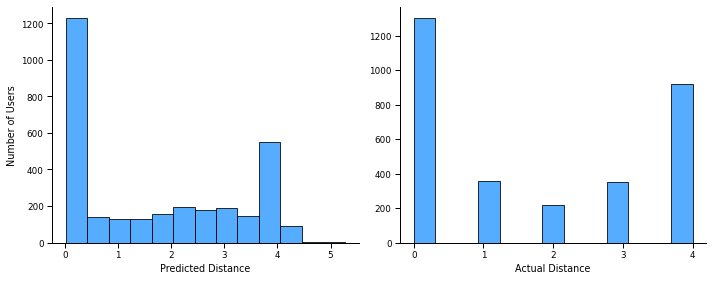

In [227]:
y_pred = model.predict(x_test)

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
a = sns.histplot(y_pred, ax = ax[0], color = 'dodgerblue')
b = sns.histplot(y_test, ax = ax[1], color = 'dodgerblue')
a.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
b.set(xlabel = 'Actual Distance', ylabel = '', xticks = [0, 1, 2, 3, 4])
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_predicted_distance.png', dpi = 2400)

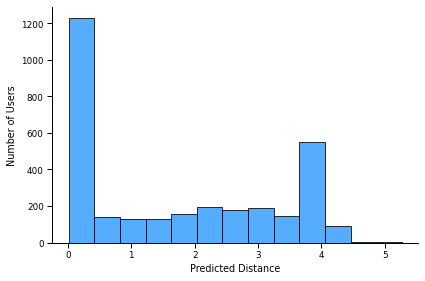

In [228]:
x = sns.histplot(y_pred, color = 'dodgerblue')
x.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_predicted_distance')

Are the two distributions the same?

We can assess this with a two-sided Kolmogorov-Smirnov test.

In [229]:
from scipy.stats import ks_2samp

ks_2samp(y_pred, y_test, alternative = 'two-sided')

KstestResult(statistic=0.4142857142857143, pvalue=2.0823717281278733e-242)

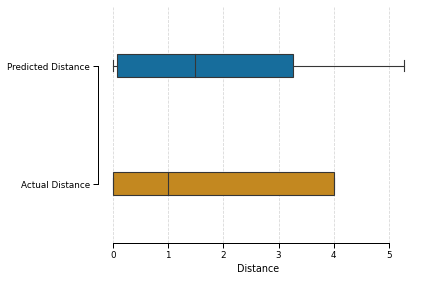

In [230]:
p = sns.boxplot(
    data = [y_pred, y_test], width = 0.2, linewidth = 1.1, notch = False, showfliers = False,
    palette = sns.color_palette('colorblind'), orient = 'h'
)
p.set(yticklabels = ['Predicted Distance', 'Actual Distance'], xlabel = 'Distance')
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True)
plt.tight_layout()
plt.show()

In [231]:
permutation_results = permutation_importance(
    estimator = model, X = x_test, y = y_test, scoring = 'neg_mean_poisson_deviance', n_repeats = 10, random_state = 42
)

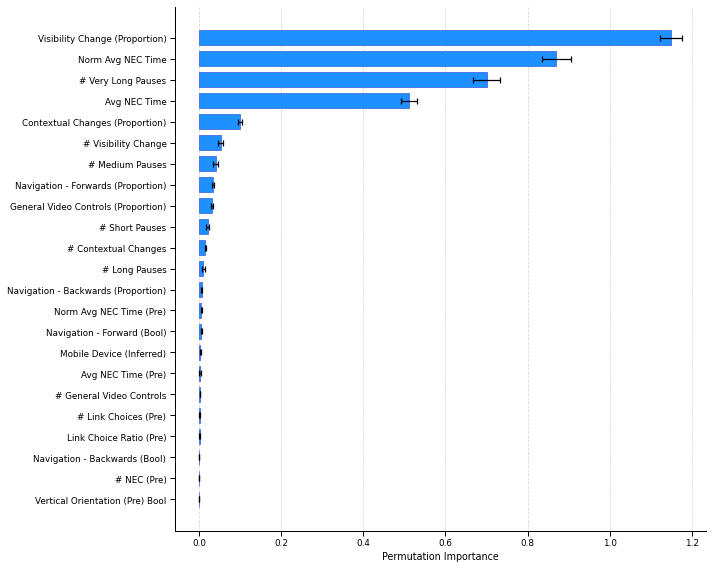

In [232]:
sorted_idx = permutation_results.importances_mean.argsort()
columns_sorted = x_test.columns[sorted_idx]
columns_std = permutation_results.importances_std[sorted_idx]
columns_m = permutation_results.importances_mean[sorted_idx]

fig, ax = plt.subplots(figsize = (10, 8))
error_kw = dict(lw = 1.25, capsize = 3, capthick = 1.25)
ax.barh(
    columns_sorted, columns_m, xerr = columns_std, align = 'center',
    error_kw = error_kw, height = 0.7, color = 'dodgerblue', edgecolor = 'royalblue'
)
ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
ax.set_axisbelow(True)
ax.set_xlabel('Permutation Importance')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_permutation_importance.png')

**Accumulated Local Effects**

The relative impact on the prediction for given feature values.

In [233]:
from alibi.explainers import ALE, plot_ale

model_ale = ALE(model.predict, feature_names = features, target_names = ['distance'])
model_explain = model_ale.explain(x_train.values)
model_explain.feature_names

array(['Avg NEC Time (Pre)', 'Norm Avg NEC Time (Pre)',
       '# Link Choices (Pre)', '# NEC (Pre)', 'Link Choice Ratio (Pre)',
       'Avg NEC Time', 'Norm Avg NEC Time', '# Short Pauses',
       '# Medium Pauses', '# Long Pauses', '# Very Long Pauses',
       'Vertical Orientation (Pre) Bool', 'Navigation - Backwards (Bool)',
       'Navigation - Forward (Bool)', '# Contextual Changes',
       '# General Video Controls', 'Navigation - Backwards (Proportion)',
       'Navigation - Forwards (Proportion)',
       'Contextual Changes (Proportion)',
       'General Video Controls (Proportion)', 'Mobile Device (Inferred)',
       'Visibility Change (Proportion)', '# Visibility Change'],
      dtype='<U35')

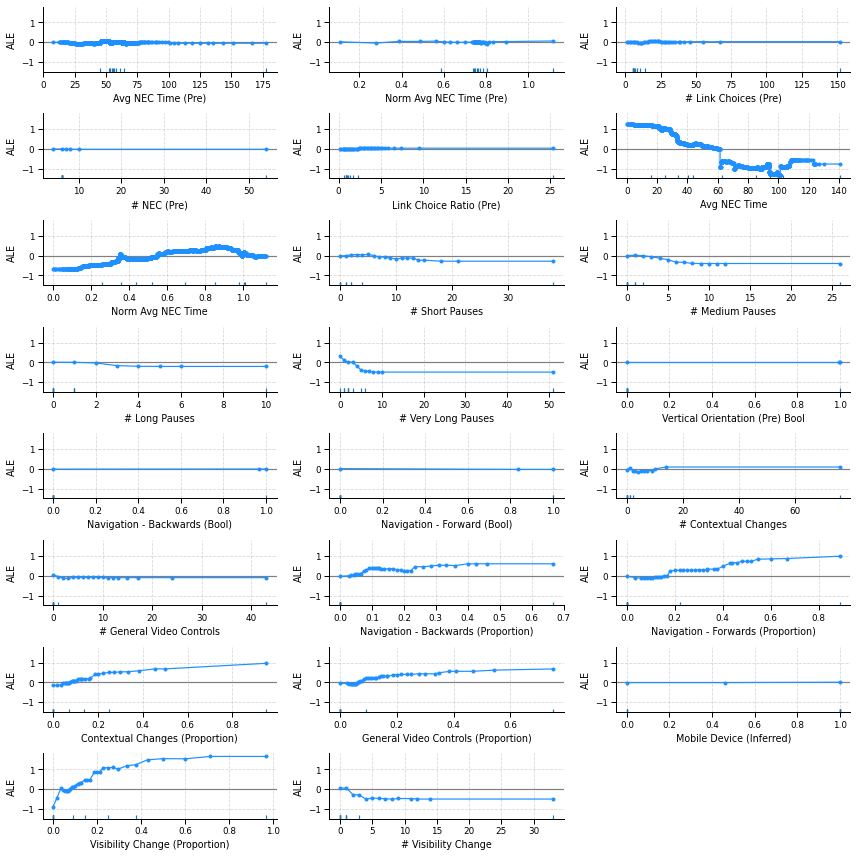

In [234]:
axes = plot_ale(
    model_explain,
    fig_kw = {'figwidth': 12, 'figheight': 12},
    line_kw = {'color': 'dodgerblue'}
)

for ax in axes.ravel()[:-1]:
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_ale_all_features.png')

We can see that the visibility change (proportion) has the strongest effect on the prediction of the model. Similar to the other notebook - where this feature was included into the contextual features - the contextual features (proportion) has a positive linear effect on the model after 0.2 (20%). The number of visibility changes negative effects the prediction - pushing it towards predicting small values. A similar effect (as previously) is seen with the navigiation proportion.

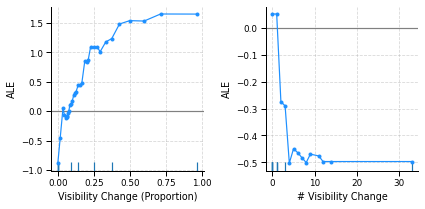

In [235]:
axes = plot_ale(
    model_explain, features = ['Visibility Change (Proportion)', '# Visibility Change'],
    fig_kw = {'figwidth': 6, 'figheight': 3},
    line_kw = {'color': 'dodgerblue'},
    sharey = None 
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None 
    
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_ale_visibility_change.png')

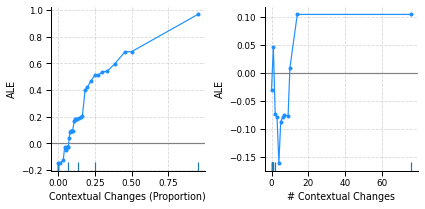

In [236]:
axes = plot_ale(
    model_explain, features = ['Contextual Changes (Proportion)', '# Contextual Changes'],
    line_kw = {'color': 'dodgerblue'},
    fig_kw = {'figwidth': 6, 'figheight': 3},
    sharey = None
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None 

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_ale_contextual_changes.png')

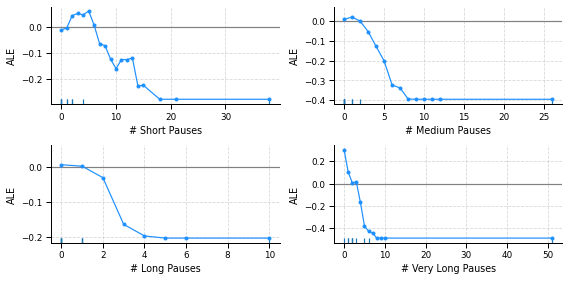

In [237]:
axes = plot_ale(
    model_explain, 
    features = ['# Short Pauses', '# Medium Pauses', '# Long Pauses', '# Very Long Pauses'], 
    fig_kw = {'figwidth': 8, 'figheight': 4},
    line_kw = {'color': 'dodgerblue'},
    sharey = None,
    n_cols = 2
)

for ax in axes.ravel()[0:4]:
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi_ale_pauses.png')

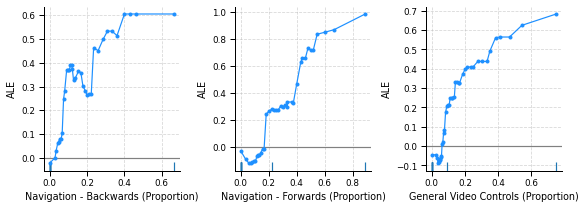

In [238]:
axes = plot_ale(
    model_explain, 
    features = ['Navigation - Backwards (Proportion)', 'Navigation - Forwards (Proportion)', 'General Video Controls (Proportion)'], 
    fig_kw = {'figwidth': 8, 'figheight': 3}, 
    line_kw = {'color': 'dodgerblue'},
    sharey = None,
    n_cols = 3
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-ale-other-metrics.png')

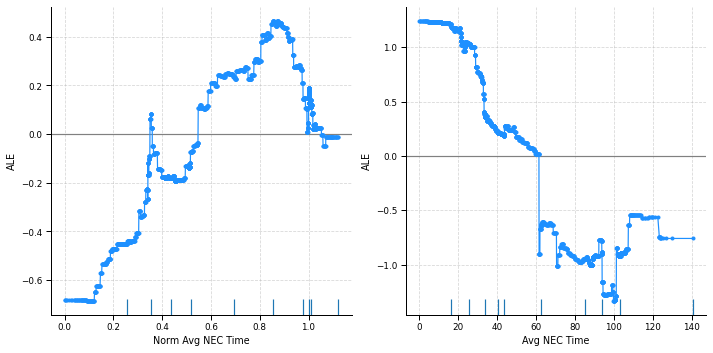

In [239]:
axes = plot_ale(
    model_explain, 
    features = ['Norm Avg NEC Time', 'Avg NEC Time'],
    fig_kw = {'figwidth': 10, 'figheight': 5},
    line_kw = {'color': 'dodgerblue'},
    sharey = None
)

for ax in axes.ravel():
    ax.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    ax.legend_ = None
    
sns.despine()
plt.tight_layout()
plt.show()

In [240]:
import shap 

explainer = shap.Explainer(model)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(x_test)

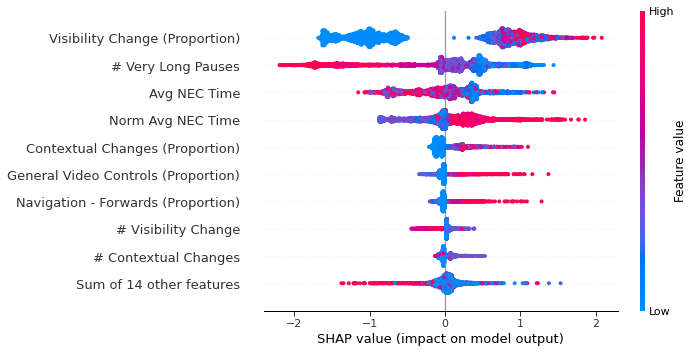

In [241]:
shap.plots.beeswarm(shap_values, show = False, plot_size = (10, 5))

plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-shap-beeswarm.png')

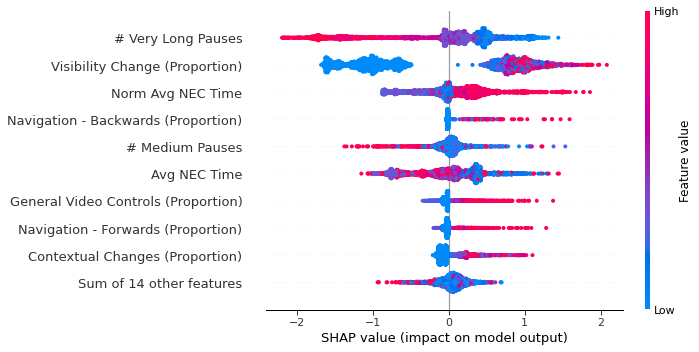

In [242]:
# high impacts for individual features we can instead sort by the max absolute value
shap.plots.beeswarm(shap_values, order = shap_values.abs.max(0))

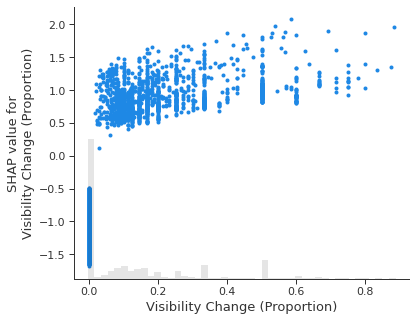

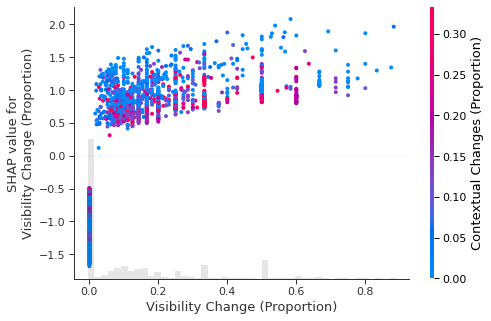

In [243]:
shap.plots.scatter(shap_values[:, 'Visibility Change (Proportion)'])
shap.plots.scatter(shap_values[:, 'Visibility Change (Proportion)'], color = shap_values)

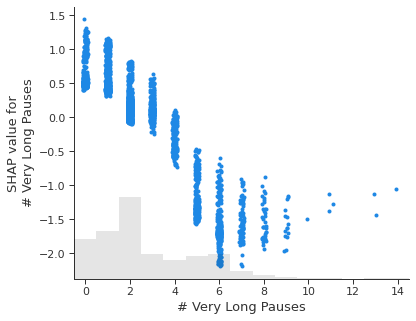

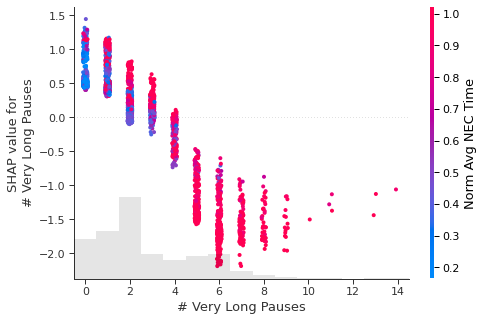

In [244]:
shap.plots.scatter(shap_values[:, '# Very Long Pauses'])
shap.plots.scatter(shap_values[:, '# Very Long Pauses'], color = shap_values)

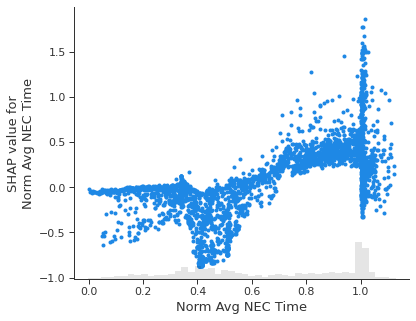

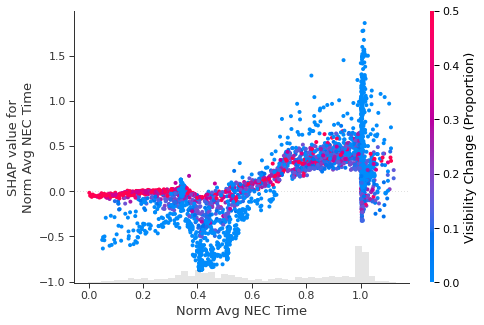

In [245]:
shap.plots.scatter(shap_values[:, 'Norm Avg NEC Time'])
shap.plots.scatter(shap_values[:, 'Norm Avg NEC Time'], color = shap_values)

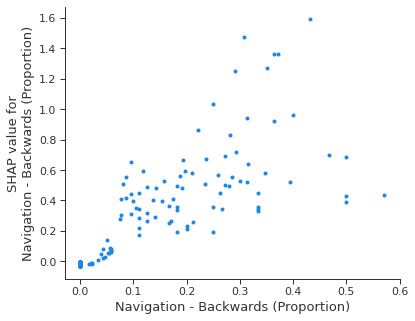

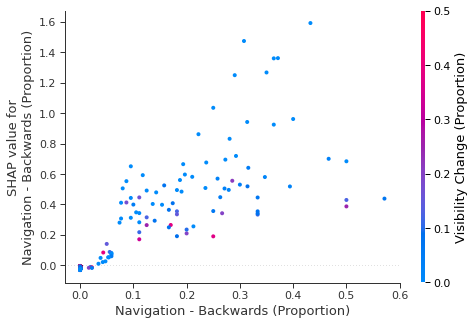

In [246]:
shap.plots.scatter(shap_values[:, 'Navigation - Backwards (Proportion)'], hist = False)
shap.plots.scatter(shap_values[:, 'Navigation - Backwards (Proportion)'], color = shap_values, hist = False)

**Relationship to Engagement**

In [247]:
from lib.helpers import process_ues_user_metrics as process_ues

ues_users = process_ues(ues_users, group_context = 'alternative_groupings')
ues_users['ues_group'] = np.where(ues_users['UES-Score'] <= ues_users['UES-Score'].median(), 'Low', 'High')

In [248]:
from lib.helpers import model_performance

ues_users['distance_predicted'] = model.predict(ues_users[features])
model_performance(ues_users['distance'], ues_users['distance_predicted'])

MSE: 0.080
MAE: 0.159
Mean Poisson Deviance: 0.318


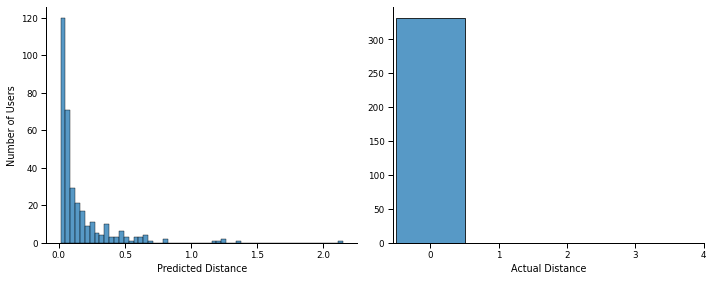

In [249]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

a = sns.histplot(ues_users['distance_predicted'], ax = ax[0])
b = sns.histplot(ues_users['distance'], ax = ax[1])
a.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
b.set(xlabel = 'Actual Distance', ylabel = '', xticks = [0, 1, 2, 3, 4])

sns.despine()
plt.tight_layout()
plt.show()

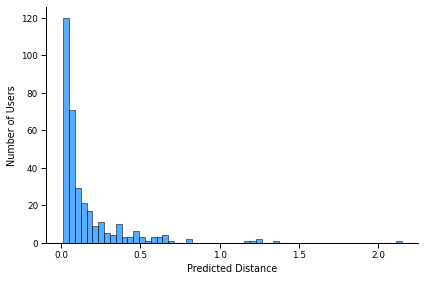

In [250]:
p = sns.histplot(ues_users['distance_predicted'], color = 'dodgerblue')
p.set(xlabel = 'Predicted Distance', ylabel = 'Number of Users')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-ues-predicted-distance-distributions.png')

In [251]:
ues_users.groupby('ues_group')['distance_predicted'].describe()

,count,mean,std,min,25%,50%,75%,max
ues_group,,,,,,,,
High,149.0,0.138849,0.186254,0.012954,0.036496,0.054582,0.154569,1.255047
Low,183.0,0.175599,0.265506,0.013359,0.044125,0.081923,0.172733,2.149654


In [252]:
from pingouin import normality, mwu 

normality(data = ues_users[ues_users['ues_group'] == 'Low']['distance_predicted'], method = 'shapiro', alpha = 0.05)

,W,pval,normal
distance_predicted,0.554585,1.951996e-21,False


In [253]:
normality(data = ues_users[ues_users['ues_group'] == 'High']['distance_predicted'], method = 'shapiro', alpha = 0.05)

,W,pval,normal
distance_predicted,0.649704,2.439652e-17,False


In [254]:
mwu(x = ues_users[ues_users['ues_group'] == 'Low']['distance_predicted'], y = ues_users[ues_users['ues_group'] == 'High']['distance_predicted'])

,U-val,tail,p-val,RBC,CLES
MWU,15800.5,two-sided,0.012752,-0.158947,0.579473


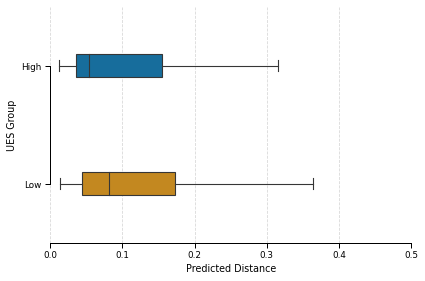

The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
The package pingouin is out of date. Your version is 0.3.9, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


In [255]:
p = sns.boxplot(
    data = ues_users.sort_values(by = 'ues_group'), x = 'distance_predicted', y = 'ues_group',
    width = 0.2, linewidth = 1.1, notch = False, orient = 'h', showfliers = False,
    palette = sns.color_palette('colorblind')
)
p.set(ylabel = 'UES Group', xlabel = 'Predicted Distance', xlim = (0, 0.5))
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True)
plt.tight_layout()
plt.show()
# plt.savefig('plots/malawi-ues-predicted-distance-boxplot.png')

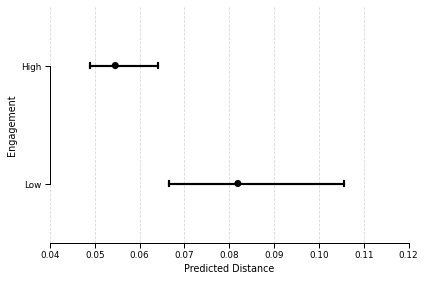

In [259]:
p = sns.pointplot(
    data = ues_users.sort_values(by = 'ues_group'), x = 'distance_predicted', y = 'ues_group', 
    join = False, capsize = 0.05, color = 'black', orient = 'h', 
    estimator = np.median 
)
p.set(ylabel = 'Engagement', xlabel = 'Predicted Distance', xlim = (0.04, 0.12))
p.xaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
p.set_axisbelow(True)
sns.despine(trim = True) 
plt.tight_layout()
plt.show()